# Wasserstein interpolation of synthetic worm images

The central assumption made by all of our OT-based worm straigtening methods is that, for microscopy videos with high enough sample rates, OT can work as an approximate model of local worm motion between successive frames. This notebook shows how OT-based (Wasserstein) interpolation can be used to accurately predict the positions of moving cells between two known frames. The data used is synthetic, generated by the `create_syn_data_2d.ipynb` notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import ot
from ipywidgets import interact

### Parameters

In [3]:
# Path to file containing frames
IN_FPATH = '/home/mn2822/Desktop/WormOT/data/synthetic/fast_2d/gmm_data_2d.h5'

# Time point to use as first frame
T_FRAME = 0

# Entropic regularization parameter. Increasing the value of this parameter
# will cause the OT algorithm to run faster, at the cost of adding more
# entropy to the transportation matrix
REG = 0.0005

### Load data

In [4]:
# Load set of frames from file
with h5py.File(IN_FPATH, 'r') as f:
    data = np.array(f.get('red'))
    
# Get dimensions of data
nx_1 = data.shape[0]
nx_2 = data.shape[1]
nt = data.shape[2]

# Select sequence of frames to look at 
frame_1 = data[:, :, T_FRAME]
frame_2 = data[:, :, T_FRAME + 1]
frame_3 = data[:, :, T_FRAME + 2]

# Normalize frames
frame_1 = frame_1 / sum(frame_1.flatten())
frame_2 = frame_2 / sum(frame_2.flatten())
frame_3 = frame_3 / sum(frame_3.flatten())

### Compute Wasserstein interpolation between first and third frame

In [5]:
# Compute distance matrix between all grid points
[xg_1, xg_2] = np.meshgrid(np.arange(nx_1), np.arange(nx_2))
x_vals = np.hstack((xg_1.reshape(-1, 1), xg_2.reshape(-1, 1)))
M = ot.utils.dist(x_vals)

# Normalize distance matrix -- this prevents conditioning issues
M = M / np.median(M)

# Compute barycenter between first and third frame to use as interpolant
A = np.hstack((frame_1.reshape(-1, 1), frame_3.reshape(-1, 1)))
interp_vec = ot.bregman.barycenter(A, M, REG, np.array([0.5, 0.5]))
interp_img = interp_vec.reshape((nx_1, nx_2))

### Compute mean squared error between second frame and interpolation

In [6]:
mse = sum((frame_2.flatten() - interp_vec) ** 2) / interp_vec.shape[0]
print(f'MSE: {mse}')

MSE: 1.922315407197938e-08


### Compute Wasserstein distance between second frame and interpolation

In [7]:
#[gamma, log] = ot.sinkhorn(
#    frame_2.flatten(), interp_img.flatten(), M, REG, log=True)
#
#err_wass = log['err'][-1]
#print(f'Wasserstein error: {err_wass}')

### Plot results

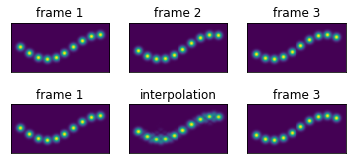

In [8]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, gridspec_kw={'hspace': -0.4})

axs[0, 0].imshow(frame_1.T)
axs[0, 0].set_title('frame 1')

axs[1, 0].imshow(frame_1.T)
axs[1, 0].set_title('frame 1')

axs[0, 2].imshow(frame_3.T)
axs[0, 2].set_title('frame 3')

axs[1, 2].imshow(frame_3.T)
axs[1, 2].set_title('frame 3')

axs[0, 1].imshow(frame_2.T)
axs[0, 1].set_title('frame 2')

axs[1, 1].imshow(interp_img.T)
axs[1, 1].set_title('interpolation')

plt.xticks([])
plt.yticks([]);